# Figure 5B: Results of profile experiments

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('styles.mplstyle')
from helpers import highlight_highest_scores
from helpers import score_heatmap
from helpers import cm2inch

## Load all scores

In [2]:
scores = []
runs = []
for run in range(5):
    scores_fn = f'../results/run-{run}/profile-run-{run}/profile-run-{run}-scores.csv'
    if os.path.exists(scores_fn):
        scores.append(pd.read_csv(scores_fn, index_col=0))
        runs.append(run)
    else:
        print(f'Results for run {run} could not be found')

In [3]:
df = (pd.concat(scores, keys=runs, names=['run', 'index'])
        .reset_index()
        .drop('index', axis=1))

In [4]:
means = df.groupby(['subset', 'genre', 'profile']).mean() * 100
stds  = df.groupby(['subset', 'genre', 'profile']).std() * 100

## Make a heatmap with scores

In [5]:
PROFILES = ['pitch_class', 'pitch', 'repetition']
GENRES = ['responsory', 'antiphon']

In [6]:
def reshape_df(df, score, subset, split, index=PROFILES, columns=GENRES):
    """Reshape a dataframe with all scores to the slice of interest:
    with genres as columns and profiles as index, and containing only
    one type of score as values"""
    return (
        pd.pivot_table(
            df.loc[subset],
            columns='genre',
            index='profile', 
            values=f'{split}_{score}'
        ).loc[index, columns]
    )

In [7]:
def show_scores(means, stds, score, subset, split, 
                line_length=.45, line_y=.3, lh=.35, tp=.15,
                labels=True, title=True,
                fmt='${mu:.1f}^{{\pm {sigma:.1f}}}$'):
    """Generate a heatmap with scores"""
    subset_means = reshape_df(means, score, subset, split)
    subset_stds = reshape_df(stds, score, subset, split)
    score_heatmap(subset_means, subset_stds,
                  vmin=0, vmax=100, cbar=False,
                  cmap='viridis', fmt=fmt,
                  yticklabels=[f.replace('_', ' ') + '\nprofile' 
                               for f in PROFILES])
    
    highlight_highest_scores(subset_means, axis=0, tol=1, 
                             line_y=line_y, line_length=line_length)
    
    if labels:
        plt.ylabel('profile')
        plt.xlabel('genre')
    else:
        plt.ylabel(None)
        plt.xlabel(None)
    plt.yticks(rotation=0)
    
    if title:
        title = f'{split.title()} {score.replace("weighted_", "")}'
        plt.text(0, -tp-2*lh, title, va='bottom', fontweight='bold')
        plt.text(0, -tp-lh, f'Profile approach on {subset} data', va='bottom')
        plt.text(0, -tp, (
            'showing $\mathrm{mean}^{\pm\mathrm{std.dev}}$ '
            f'over {len(runs)} runs'
            ), va='bottom', size=5.5, alpha=.5)
    plt.tight_layout()

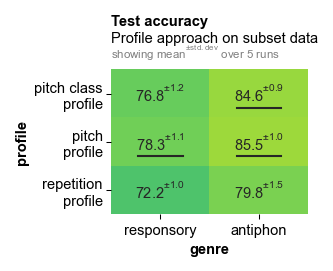

In [8]:
plt.figure(figsize=cm2inch(5.5, 5), dpi=150)
show_scores(means, stds, 'accuracy', 'subset', 'test')

## Generate all heatmaps

In [9]:
for subset in ['full', 'subset']:
    for split in ['train', 'test']:
        for score in ['accuracy', 'weighted_f1', 'weighted_precision', 'weighted_recall']:
            plt.ioff() # Turn off interactive plotting
            plt.figure(figsize=cm2inch(5.5, 5))
            show_scores(means, stds, score, subset, split)
            fig_fn = f'../figures/fig05b-profile/fig05b-{subset}-{split}-{score}.pdf'
            plt.savefig(fig_fn)
            plt.close()

## Generate plot for final figure

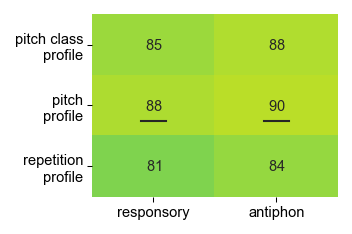

In [10]:
cols = 2
rows = 3
plt.figure(figsize=cm2inch(2*(cols+1), rows+1), dpi=150)
show_scores(means, stds, 'weighted_f1', 'full', 'test',
           fmt='${mu:.0f}$', line_length=.2, line_y=.25,
           labels=False, title=False)
plt.savefig(f'../figures/fig05/fig05-profile-test-f1.pdf')